实战二：寻找普通苹果与其他苹果
任务:根据original_data样本，建立模型对test_data的图片进行普通/其他苹果判断.
1) 数据增强，扩充确认为普通苹果的样本数量
2) 特征提取，使用VGG16模型提取图像特征
3) 图片批量处理
4) Kmeans模型尝试普通、其他苹果聚类
5) 基于标签数据矫正结果，并可视化
6) Meanshift模型提升模型表现
7) 数据降维PCA处理，提升模型表现

特点:样本少、部分标注(且都是正样本)、负样本类别不可穷尽、图像处理

In [4]:
#数据增强、扩充
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
path = 'original_data'
dst_path = 'gen_data'
#rotation_range 旋转、width_shift_range水平平移、height_shift_range垂直平移
#shear_range 剪切强度、zoom_range缩放范围、horizontal_flip水平翻转
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.02,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

gen = datagen.flow_from_directory(
    path,
    target_size=(224, 224),
    batch_size=2,
    save_to_dir=dst_path,
    save_prefix='gen',
    save_format='jpg'
)

for i in range(100):
    #gen.next()
    next(gen)

Found 10 images belonging to 2 classes.


In [ ]:
#图片加载，单张图片展示、图片提取
from keras.preprocessing.image import load_img, img_to_array
img_path = 'original_data/1.jpg'
img = load_img(img_path, target_size=(224, 224))
type(img)

PIL.Image.Image

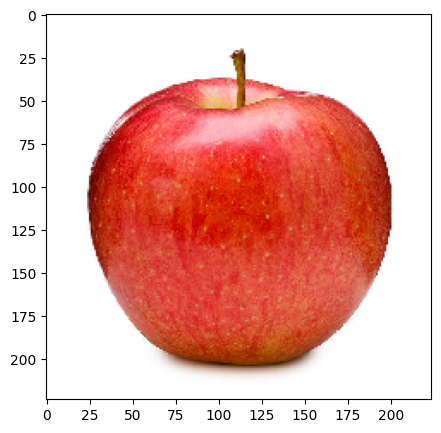

In [6]:
#显示
import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(5, 5))
plt.imshow(img)

In [8]:
#格式转换
img = img_to_array(img)
type(img)
print(img.shape)

(224, 224, 3)


In [ ]:
#VGG16 卷积神经网络模型
from keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np 
model_vgg = VGG16(weights='imagenet', include_top=False)
#数据增加维度,相当于增加序列，第几张图片
x = np.expand_dims(img, axis=0)
print(x.shape)
#转换格式，适配vgg16
x = preprocess_input(x)
print(x.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)


In [11]:
#特征提取
features = model_vgg.predict(x)
print(features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
(1, 7, 7, 512)


In [12]:
#flatten
features = features.reshape(1, 7*7*512)
print(features.shape)

(1, 25088)


In [14]:
#list all datas
import os
folder = 'train_data'
dirs = os.listdir(folder)
print(dirs)
img_path = []
for i in dirs:
    if os.path.splitext(i)[1] == '.jpg':
        img_path.append(i)

img_path = [folder + '/' + i for i in img_path]
print(img_path)


['gen_0_117829.jpg', 'gen_0_1947613.jpg', 'gen_0_2048614.jpg', 'gen_0_2404831.jpg', 'gen_0_2503849.jpg', 'gen_0_2689501.jpg', 'gen_0_329573.jpg', 'gen_0_4776514.jpg', 'gen_0_4843536.jpg', 'gen_0_5114194.jpg', 'gen_0_5411682.jpg', 'gen_0_5525038.jpg', 'gen_0_5563922.jpg', 'gen_0_654016.jpg', 'gen_0_6800730.jpg', 'gen_0_7811861.jpg', 'gen_0_8408136.jpg', 'gen_0_8830302.jpg', 'gen_0_9487505.jpg', 'gen_0_976285.jpg', 'gen_1_1234526.jpg', 'gen_1_1626273.jpg', 'gen_1_1901146.jpg', 'gen_1_3544484.jpg', 'gen_1_3744591.jpg', 'gen_1_3775363.jpg', 'gen_1_3976901.jpg', 'gen_1_4143459.jpg', 'gen_1_4176943.jpg', 'gen_1_4937546.jpg', 'gen_1_5959207.jpg', 'gen_1_60415.jpg', 'gen_1_6541078.jpg', 'gen_1_7102305.jpg', 'gen_1_7315378.jpg', 'gen_1_7359034.jpg', 'gen_1_7678579.jpg', 'gen_1_7940235.jpg', 'gen_1_7960265.jpg', 'gen_1_8230844.jpg', 'gen_2_1525926.jpg', 'gen_2_1542225.jpg', 'gen_2_1608791.jpg', 'gen_2_2087155.jpg', 'gen_2_224490.jpg', 'gen_2_2700109.jpg', 'gen_2_3375366.jpg', 'gen_2_4431863.jpg'

In [20]:
#定义方法
def model_process(img_path, model):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    x = np.expand_dims(img, axis=0)
    #转换格式，适配vgg16
    x = preprocess_input(x)
    x_vgg = model_vgg.predict(x)
    x_vgg = x_vgg.reshape(1, 7*7*512)
    return x_vgg

In [21]:
#图像批量处理
features_train = np.zeros([len(img_path), 7*7*512])
for i in range(len(img_path)):
    feature_i = model_process(img_path[i], model_vgg)
    print(img_path[i])
    features_train[i] = feature_i

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
train_data/gen_0_117829.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
train_data/gen_0_1947613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
train_data/gen_0_2048614.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
train_data/gen_0_2404831.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
train_data/gen_0_2503849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
train_data/gen_0_2689501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
train_data/gen_0_329573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
train_data/gen_0_4776514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
train_data/gen_0_4843536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
train_data/gen_0_5114194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
train_data/gen_0_5411682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
train_data/gen_0_5525038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
train_data/gen_0_5563922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
train_data/gen_0_654016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
train_data/g

In [22]:
print(features_train.shape)

(230, 25088)


In [23]:
#define x and y
x = features_train


In [ ]:
#建立kmeans 模型,聚类，两个类别，属于无监督学习
from sklearn.cluster import KMeans
cnn_kmeans = KMeans(n_clusters=2,max_iter=2000)
cnn_kmeans.fit(x)

KMeans(max_iter=2000, n_clusters=2)

In [25]:
#预测
y_predict_kmeans = cnn_kmeans.predict(x)
print(y_predict_kmeans)

[1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1
 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0
 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1
 1 0 0 0 1 0 0 0]


In [26]:
from collections import Counter
#预测结果统计
print(Counter(y_predict_kmeans))

Counter({np.int32(0): 126, np.int32(1): 104})


In [28]:
normal_apple_id = 1


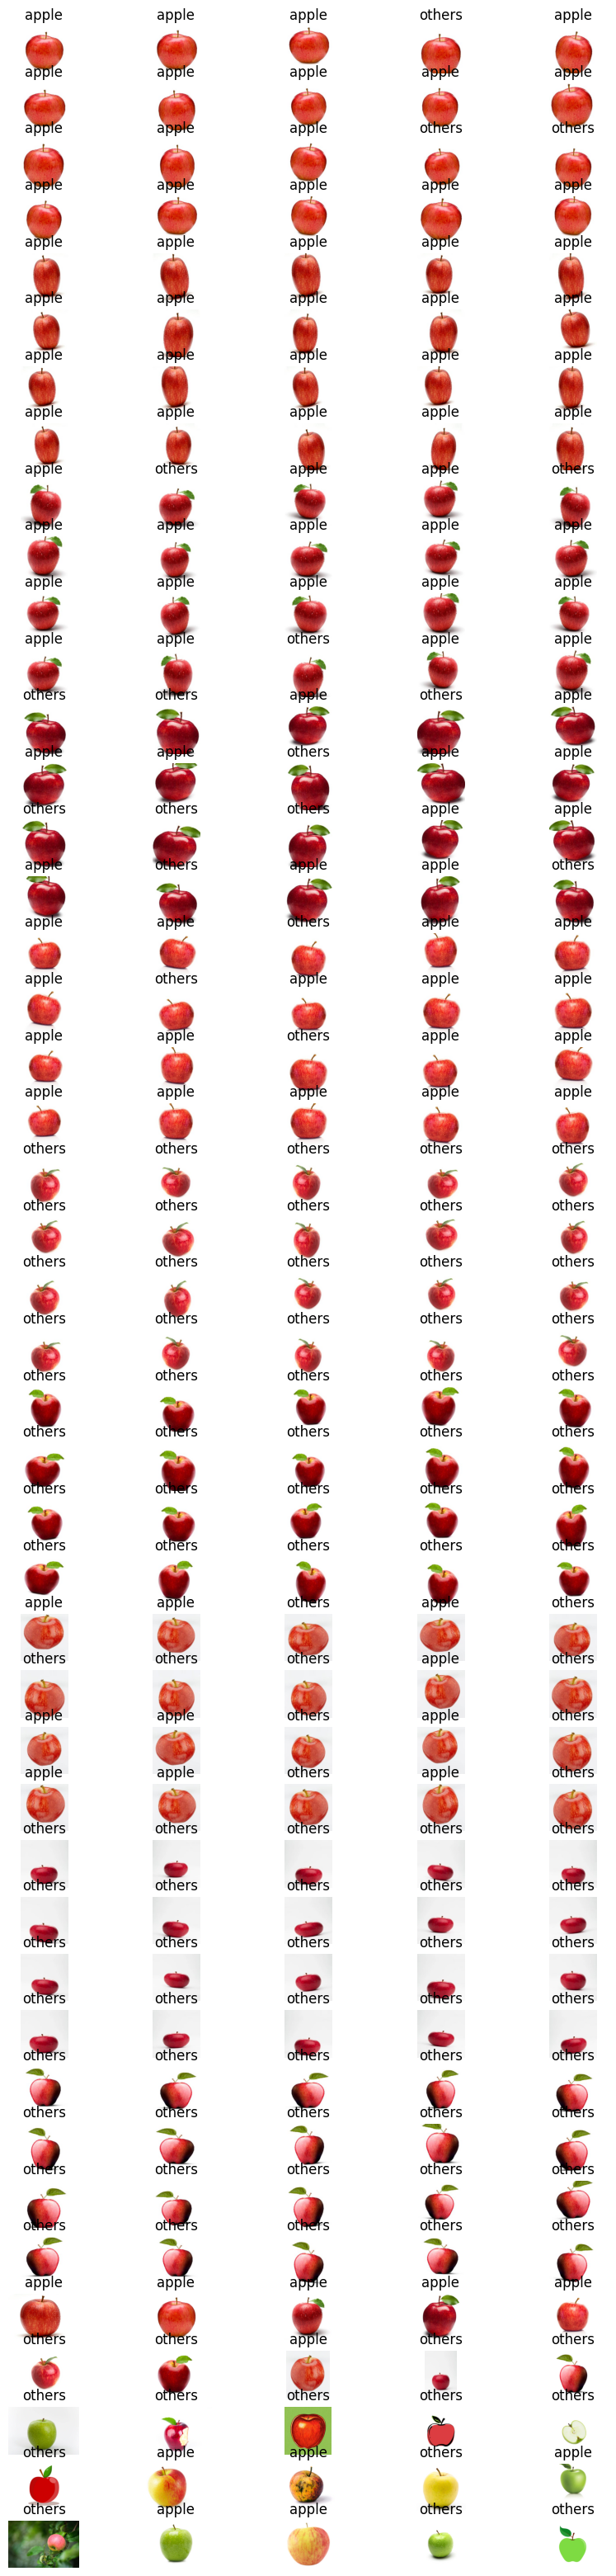

In [29]:
fig2 = plt.figure(figsize=(10, 40))
for i in range(45):
    for j in range(5):
        img = load_img(img_path[i*5 + j])
        plt.subplot(45, 5, i*5 + j + 1)
        plt.title('apple' if y_predict_kmeans[i*5 +j] == normal_apple_id else 'others')
        plt.imshow(img)
        plt.axis('off')

In [38]:
#预测测试数据
folder_test = 'test_data'
dirs = os.listdir(folder_test)
print(dirs)
test_img_path = []
for i in dirs:
    if os.path.splitext(i)[1] == '.jpg':
        test_img_path.append(i)

test_img_path = [folder_test + '/' + i for i in test_img_path]

features_test = np.zeros([len(test_img_path), 7*7*512])
for i in range(len(test_img_path)):
    feature_i = model_process(test_img_path[i], model_vgg)
    print(test_img_path[i])
    features_test[i] = feature_i

['pexels-am83-13027756.jpg', 'pexels-andrea-devillier-2148893039-34844893.jpg', 'pexels-anna-nekrashevich-7214784.jpg', 'pexels-benwithlana-lana-498258353-18714943.jpg', 'pexels-clickerhappy-38068.jpg', 'pexels-ifreestock-616837.jpg', 'pexels-laura-lumimaa-1119727985-27289147.jpg', 'pexels-matthiaszomer-914911.jpg', 'pexels-mographe-30811259.jpg', 'pexels-pixabay-209449.jpg', 'pexels-shox-31665507.jpg', 'pexels-brunoscramgnon-575610.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
test_data/pexels-am83-13027756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
test_data/pexels-andrea-devillier-2148893039-34844893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
test_data/pexels-anna-nekrashevich-7214784.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
test_data/pexels-benwithlana-lana-498258353-18714943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
test_data/pexels-clickerhappy-38068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
test_data/pexels-ifreestock-616837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
test_dat

In [41]:
#define x and y
x_test = features_test
y_test_predict_kmeans = cnn_kmeans.predict(x_test)
print(Counter(y_test_predict_kmeans))


Counter({np.int32(0): 10, np.int32(1): 2})


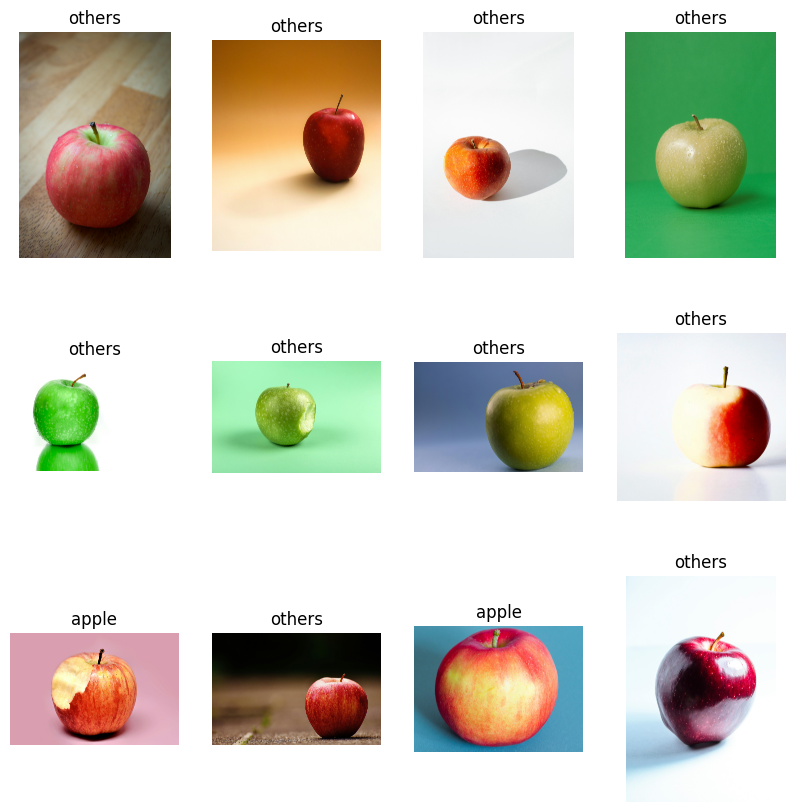

In [43]:
fig3 = plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(4):
        img = load_img(test_img_path[i*4 + j])
        plt.subplot(3,4,i*4+j+1)
        plt.title('apple' if y_test_predict_kmeans[i*4 + j] == normal_apple_id else 'others')
        plt.imshow(img)
        plt.axis('off')

kmeans 模型适合分类有多个中心点，普通苹果是中间是中心点，其它比较分散没有中心点。
尝试用meanshfit 模型

In [45]:
#meanshift
from sklearn.cluster import MeanShift,estimate_bandwidth
bw = estimate_bandwidth(x, n_samples=140)
print(bw)

cnn_ms = MeanShift(bandwidth=bw)
cnn_ms.fit(x)


1446.258715757795


MeanShift(bandwidth=np.float64(1446.258715757795))

In [47]:
#预测
y_predict_ms = cnn_ms.predict(x)
print(Counter(y_predict_ms))

Counter({np.int64(0): 224, np.int64(6): 1, np.int64(1): 1, np.int64(5): 1, np.int64(2): 1, np.int64(3): 1, np.int64(4): 1})


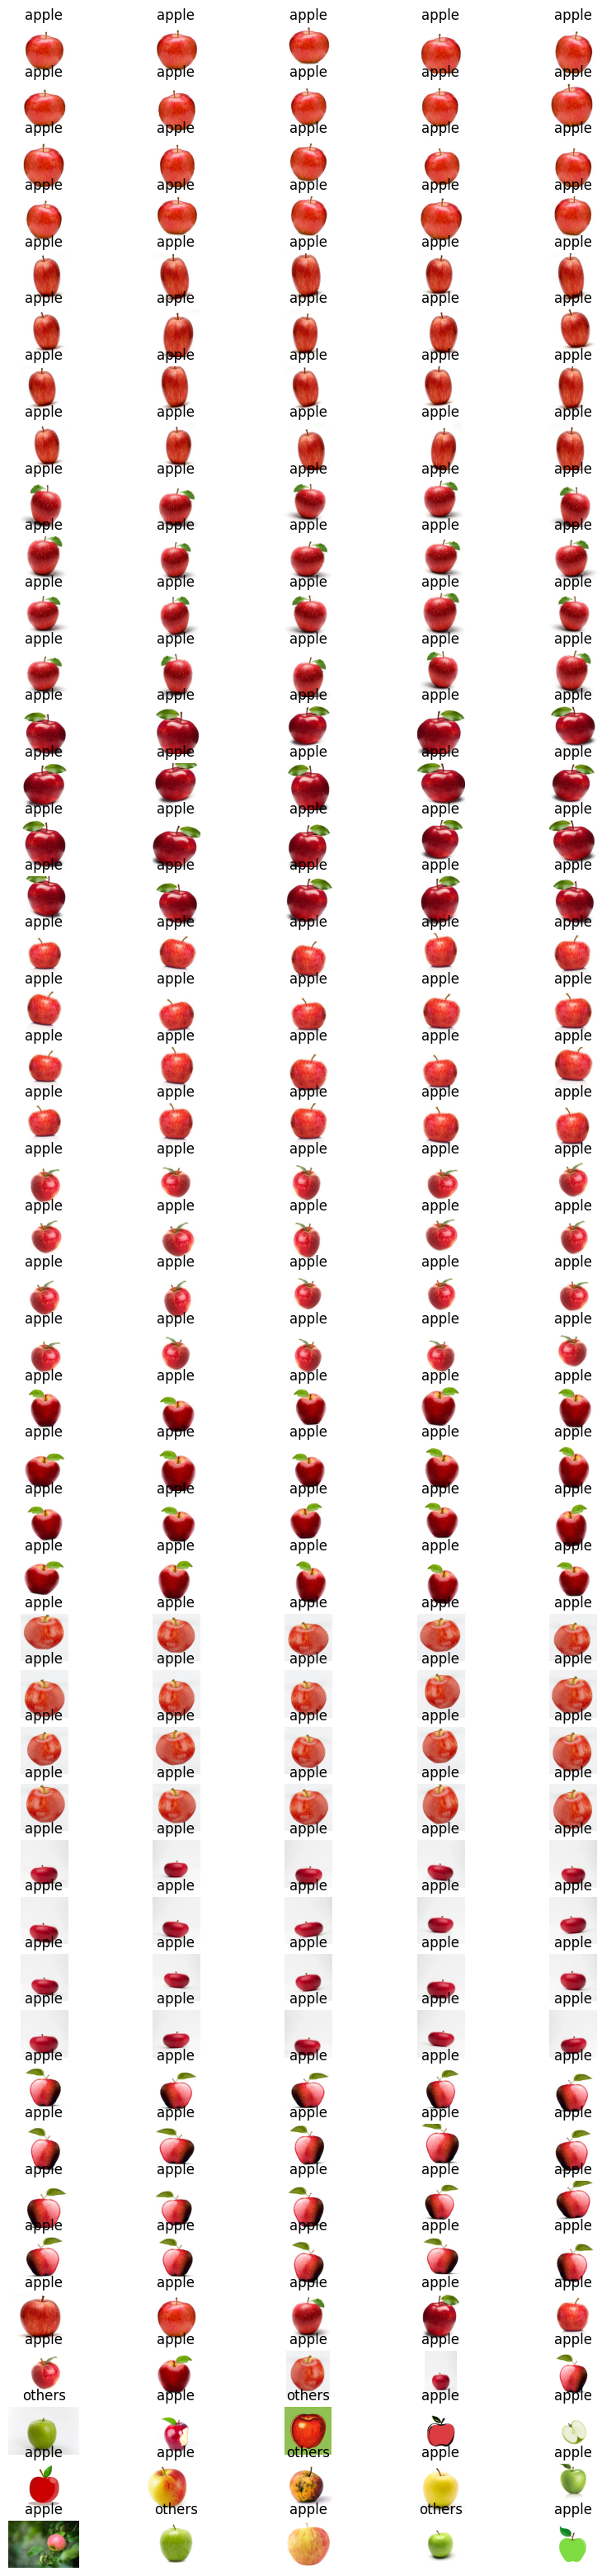

In [48]:
normal_apple_id = 0
fig4 = plt.figure(figsize=(10, 40))
for i in range(45):
    for j in range(5):
        img = load_img(img_path[i*5 + j])
        plt.subplot(45, 5, i*5 + j + 1)
        plt.title('apple' if y_predict_ms[i*5 +j] == normal_apple_id else 'others')
        plt.imshow(img)
        plt.axis('off')

In [49]:

y_test_predict_ms = cnn_ms.predict(x_test)
print(Counter(y_test_predict_ms))

Counter({np.int64(0): 12})


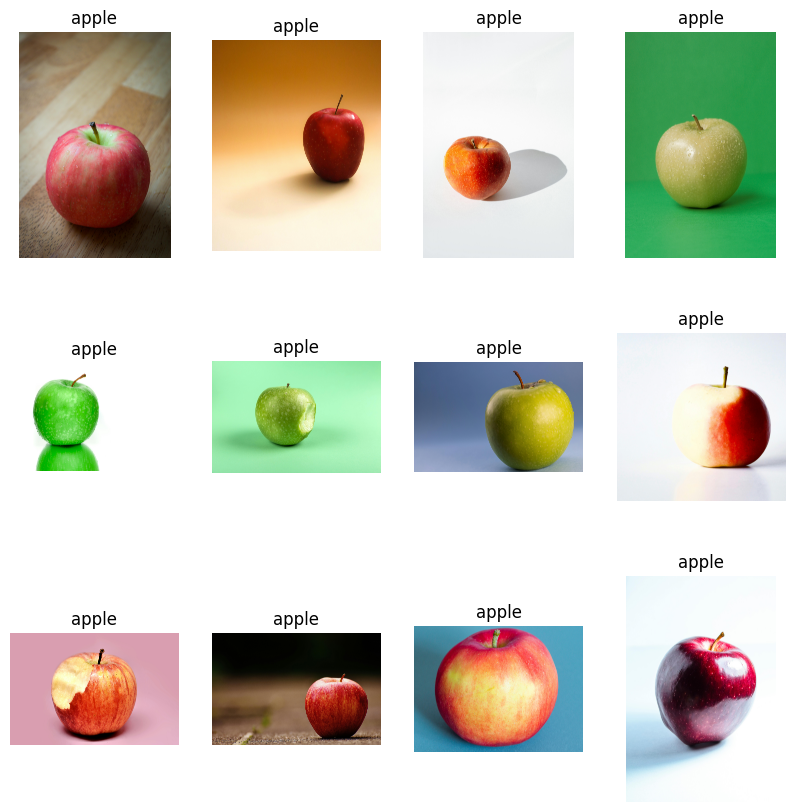

In [50]:
fig5 = plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(4):
        img = load_img(test_img_path[i*4 + j])
        plt.subplot(3,4,i*4+j+1)
        plt.title('apple' if y_test_predict_ms[i*4 + j] == normal_apple_id else 'others')
        plt.imshow(img)
        plt.axis('off')

In [ ]:
#优化，去掉噪声，PCA 主成分分析
from sklearn.preprocessing import StandardScaler
stds = StandardScaler()
x_norms = stds.fit_transform(x)

from sklearn.decomposition import PCA
#224 降到200维
pca = PCA(n_components=200)
x_pca = pca.fit_transform(x_norms)

In [52]:
#计算方差，查看保留的主成分比例
var_ratio = pca.explained_variance_ratio_
print(np.sum(var_ratio))


0.9866494822893591


In [54]:
print(x_pca.shape, x.shape)

(230, 200) (230, 25088)


In [63]:
bw = estimate_bandwidth(x, n_samples=140)
print(bw)

cnn_pca_ms = MeanShift(bandwidth=bw)
cnn_pca_ms.fit(x_pca)

1446.258715757795


MeanShift(bandwidth=np.float64(1446.258715757795))

In [64]:
y_predict_pca_ms = cnn_pca_ms.predict(x_pca)
print(Counter(y_predict_pca_ms))

Counter({np.int64(0): 230})


In [65]:
x_test_norms = stds.transform(x_test)
x_test_pca = pca.transform(x_test_norms)
y_test_predict_pca_ms = cnn_pca_ms.predict(x_test_pca)
print(Counter(y_test_predict_pca_ms))

Counter({np.int64(0): 12})


普通/其他苹果检测实战summary:
1、通过搭建混合模型，实现了监督+无监督、机器*深度学习技术的有机结合，并在少样本情况下建立起了有效区分普通苹果与其他苹果的模型。2、针对少样本任务，掌握了生成新数据的数据增强方法;
3、更熟练的掌握了拆分经典VGG16模型并用于提取图像特征的方法;
4、完成了图像的批量处理:
5、回顾了无监督聚类算法:KMeans、Meanshift，并通过标签数据分布实现数据类别矫正;
6、成功引入PCA数据降维技术，剔除了数据中的噪音信息、降低了模型复杂度、减少了模型训练时间，并最终提高了模型表现;
7、可以考虑一些其他方法去完成任务，比如异常数据检测技术